In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root added to path: {project_root}")
print(f"Current working directory: {Path.cwd()}")

Project root added to path: /
Current working directory: /kaggle/working


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from utils import create_data_pipeline
from bilstm import BiLSTM

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
with open("/kaggle/working/letter2idx.pickle", "rb") as file:
    letter2idx = pickle.load(file)

with open("/kaggle/working/diacritic2id.pickle", "rb") as file:
    diacritic2id = pickle.load(file)

idx2letter = {value: key for key, value in letter2idx.items()}
idx2diacritic = {value: key for key, value in diacritic2id.items()}

print(letter2idx)
print(idx2letter)
print(diacritic2id)
print(idx2diacritic)

{'ظ': 0, 'ي': 1, 'غ': 2, 'ن': 3, 'ق': 4, 'ذ': 5, 'د': 6, 'خ': 7, 'ر': 8, 'ط': 9, 'ى': 10, 'م': 11, 'ل': 12, '<PAD>': 13, 'ت': 14, 'ج': 15, 'آ': 16, 'ا': 17, 'س': 18, 'ئ': 19, 'ع': 20, 'ف': 21, 'ص': 22, 'ه': 23, 'ز': 24, 'ك': 25, 'ش': 26, 'أ': 27, 'و': 28, 'ب': 29, 'ؤ': 30, 'ض': 31, 'ة': 32, 'ث': 33, 'ء': 34, 'ح': 35, 'إ': 36, ' ': 37}
{0: 'ظ', 1: 'ي', 2: 'غ', 3: 'ن', 4: 'ق', 5: 'ذ', 6: 'د', 7: 'خ', 8: 'ر', 9: 'ط', 10: 'ى', 11: 'م', 12: 'ل', 13: '<PAD>', 14: 'ت', 15: 'ج', 16: 'آ', 17: 'ا', 18: 'س', 19: 'ئ', 20: 'ع', 21: 'ف', 22: 'ص', 23: 'ه', 24: 'ز', 25: 'ك', 26: 'ش', 27: 'أ', 28: 'و', 29: 'ب', 30: 'ؤ', 31: 'ض', 32: 'ة', 33: 'ث', 34: 'ء', 35: 'ح', 36: 'إ', 37: ' '}
{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13, '': 14, '<PAD>': 15}
{0: 'َ', 1: 'ً', 2: 'ُ', 3: 'ٌ', 4: 'ِ', 5: 'ٍ', 6: 'ْ', 7: 'ّ', 8: 'َّ', 9: 'ًّ', 10: 'ُّ', 11: 'ٌّ', 12: 'ِّ', 13: 'ٍّ', 14: '', 15: '<PAD>'}


In [5]:
vocab_size = len(letter2idx) 
num_classes = len(diacritic2id)
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 38
Num classes: 16


In [6]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=diacritic2id['<PAD>'])
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_path = 'best_bilstm_model.pth'

    for epoch in range(epochs):
        model.train()

        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_X, batch_y, _, lengths in pbar:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()

                outputs = model(batch_X, lengths)

                B, T, C = outputs.shape
                loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                preds = outputs.argmax(dim=-1)
                mask = (batch_y != diacritic2id['<PAD>'])

                correct = (preds[mask] == batch_y[mask]).sum().item()
                total = mask.sum().item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                total_train_correct += correct
                total_train_tokens += total

                acc = correct / total if total > 0 else 0.0

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{acc:.4f}'
                })

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / total_train_tokens

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]') as pbar:
                for batch_X, batch_y, _, lengths in pbar:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    outputs = model(batch_X, lengths)
                    B, T, C = outputs.shape

                    loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                    preds = outputs.argmax(dim=-1)
                    mask = (batch_y != diacritic2id['<PAD>'])

                    correct = (preds[mask] == batch_y[mask]).sum().item()
                    total = mask.sum().item()

                    total_val_loss += loss.item()
                    total_val_correct += correct
                    total_val_tokens += total

                    acc = correct / total if total > 0 else 0.0

                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{acc:.4f}'
                    })

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_correct / total_val_tokens

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'val_accuracy': avg_val_acc,
                'train_loss': avg_train_loss,
                'train_accuracy': avg_train_acc
            }, best_model_path)
            print(f"  ↳ Best model saved! (val_loss: {best_val_loss:.4f})")

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }

In [7]:
def pad_collate_fn(batch):
    x_batch, y_batch, mask_batch = zip(*batch)
    lengths_x = [len(x) for x in x_batch]
    x_padded = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=letter2idx['<PAD>'])
    y_padded = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=diacritic2id['<PAD>'])
    mask_spadded = torch.nn.utils.rnn.pad_sequence(mask_batch, batch_first=True, padding_value=0)
    return x_padded, y_padded, mask_spadded, torch.tensor(lengths_x, dtype=torch.long)

In [8]:
train_dataset, train_loader = create_data_pipeline(
    corpus_path=str(project_root / '/kaggle/working/train.txt'), 
    letter2idx=letter2idx, 
    diacritic2idx=diacritic2id, 
    collate_fn=pad_collate_fn,
    batch_size=32
)

val_dataset, val_loader = create_data_pipeline(
    corpus_path=str(project_root / '/kaggle/working/val.txt'), 
    letter2idx=letter2idx, 
    diacritic2idx=diacritic2id,
    collate_fn=pad_collate_fn,
    train=False, 
    batch_size=32
)

In [17]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")

embedding_matrix = embedding_matrix.to(device)

model = BiLSTM(
    vocab_size=embedding_matrix.size(0),
    num_classes=num_classes,
    embedding_dim=768,
    pretrained_embeddings=embedding_matrix
).to(device)

In [12]:
def print_data_statistics(train_dataset, val_dataset, train_loader, val_loader, letter2idx, diacritic2id):
    print("="*80)
    print(" " * 25 + "📊 DATA STATISTICS")
    print("="*80)
    
    train_lengths = [len(x) for x, _, _ in train_dataset]
    val_lengths = [len(x) for x, _, _ in val_dataset]
    
    print(f"\n{'Dataset Sizes:':<30}")
    print(f"  {'Training samples:':<28} {len(train_dataset):>10,}")
    print(f"  {'Validation samples:':<28} {len(val_dataset):>10,}")
    print(f"  {'Total samples:':<28} {len(train_dataset) + len(val_dataset):>10,}")
    print(f"  {'Train/Val ratio:':<28} {len(train_dataset)/len(val_dataset):>10.2f}")
    
    print(f"\n{'Batch Information:':<30}")
    print(f"  {'Training batches:':<28} {len(train_loader):>10,}")
    print(f"  {'Validation batches:':<28} {len(val_loader):>10,}")
    print(f"  {'Batch size:':<28} {train_loader.batch_size:>10}")
    
    print(f"\n{'Training Sequence Lengths:':<30}")
    print(f"  {'Min length:':<28} {min(train_lengths):>10}")
    print(f"  {'Max length:':<28} {max(train_lengths):>10}")
    print(f"  {'Mean length:':<28} {np.mean(train_lengths):>10.2f}")
    print(f"  {'Median length:':<28} {np.median(train_lengths):>10.0f}")
    print(f"  {'Std deviation:':<28} {np.std(train_lengths):>10.2f}")
    print(f"  {'25th percentile:':<28} {np.percentile(train_lengths, 25):>10.0f}")
    print(f"  {'75th percentile:':<28} {np.percentile(train_lengths, 75):>10.0f}")
    print(f"  {'95th percentile:':<28} {np.percentile(train_lengths, 95):>10.0f}")
    print(f"  {'99th percentile:':<28} {np.percentile(train_lengths, 99):>10.0f}")
    
    print(f"\n{'Validation Sequence Lengths:':<30}")
    print(f"  {'Min length:':<28} {min(val_lengths):>10}")
    print(f"  {'Max length:':<28} {max(val_lengths):>10}")
    print(f"  {'Mean length:':<28} {np.mean(val_lengths):>10.2f}")
    print(f"  {'Median length:':<28} {np.median(val_lengths):>10.0f}")
    print(f"  {'Std deviation:':<28} {np.std(val_lengths):>10.2f}")
    
    print(f"\n{'Vocabulary Information:':<30}")
    print(f"  {'Vocabulary size:':<28} {len(letter2idx):>10}")
    print(f"  {'Number of diacritics:':<28} {len(diacritic2id):>10}")
    print(f"  {'Special tokens:':<28} {'<PAD>, <UNK>':>10}")
    
    total_train_chars = sum(train_lengths)
    total_val_chars = sum(val_lengths)
    print(f"\n{'Total Characters:':<30}")
    print(f"  {'Training characters:':<28} {total_train_chars:>10,}")
    print(f"  {'Validation characters:':<28} {total_val_chars:>10,}")
    print(f"  {'Total characters:':<28} {total_train_chars + total_val_chars:>10,}")
    
    print(f"\n{'Memory Estimates (approx):':<30}")
    avg_train_len = np.mean(train_lengths)
    avg_val_len = np.mean(val_lengths)
    train_batch_mem = train_loader.batch_size * max(train_lengths) * 4 / (1024**2)  # 4 bytes per int
    val_batch_mem = val_loader.batch_size * max(val_lengths) * 4 / (1024**2)
    print(f"  {'Max train batch (input):':<28} {train_batch_mem:>9.2f} MB")
    print(f"  {'Max val batch (input):':<28} {val_batch_mem:>9.2f} MB")
    
    print(f"\n{'Sequence Length Distribution:':<30}")
    bins = [0, 50, 100, 200, 300, 400, 512]
    print(f"  {'Range':<15} {'Train':<15} {'Val':<15}")
    for i in range(len(bins) - 1):
        train_count = sum(1 for l in train_lengths if bins[i] < l <= bins[i+1])
        val_count = sum(1 for l in val_lengths if bins[i] < l <= bins[i+1])
        train_pct = (train_count / len(train_lengths)) * 100
        val_pct = (val_count / len(val_lengths)) * 100
        print(f"  {f'{bins[i]}-{bins[i+1]}':<15} {f'{train_count:,} ({train_pct:.1f}%)':<15} {f'{val_count:,} ({val_pct:.1f}%)':<15}")
    
    print("\n" + "="*80)
    print("✓ Data statistics computed successfully!")
    print("="*80 + "\n")

In [13]:
print_data_statistics(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    train_loader=train_loader,
    val_loader=val_loader,
    letter2idx=letter2idx,
    diacritic2id=diacritic2id
)

                         📊 DATA STATISTICS

Dataset Sizes:                
  Training samples:               183,466
  Validation samples:               8,921
  Total samples:                  192,387
  Train/Val ratio:                  20.57

Batch Information:            
  Training batches:                 5,734
  Validation batches:                 279
  Batch size:                          32

Training Sequence Lengths:    
  Min length:                           3
  Max length:                         512
  Mean length:                      54.89
  Median length:                       33
  Std deviation:                    69.46
  25th percentile:                     16
  75th percentile:                     65
  95th percentile:                    178
  99th percentile:                    385

Validation Sequence Lengths:  
  Min length:                           3
  Max length:                         512
  Mean length:                      55.03
  Median length:               

\nModel Summary:
Total parameters: 51,261,456


Epoch 1/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 90.73it/s, Loss=0.2233, Acc=0.9263]


  ↳ Best model saved! (val_loss: 0.1659)
Epoch 1/10:
  Train Loss: 0.2666, Train Acc: 0.9120
  Val Loss: 0.1659, Val Acc: 0.9473
  LR: 0.001000


Epoch 2/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 91.88it/s, Loss=0.2005, Acc=0.9346]


  ↳ Best model saved! (val_loss: 0.1357)
Epoch 2/10:
  Train Loss: 0.1454, Train Acc: 0.9537
  Val Loss: 0.1357, Val Acc: 0.9573
  LR: 0.001000


Epoch 3/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.34it/s, Loss=0.1907, Acc=0.9382]


  ↳ Best model saved! (val_loss: 0.1244)
Epoch 3/10:
  Train Loss: 0.1248, Train Acc: 0.9604
  Val Loss: 0.1244, Val Acc: 0.9614
  LR: 0.001000


Epoch 4/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.79it/s, Loss=0.1716, Acc=0.9438]


  ↳ Best model saved! (val_loss: 0.1192)
Epoch 4/10:
  Train Loss: 0.1139, Train Acc: 0.9638
  Val Loss: 0.1192, Val Acc: 0.9629
  LR: 0.001000


Epoch 5/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 91.45it/s, Loss=0.1781, Acc=0.9429]


  ↳ Best model saved! (val_loss: 0.1161)
Epoch 5/10:
  Train Loss: 0.1069, Train Acc: 0.9660
  Val Loss: 0.1161, Val Acc: 0.9639
  LR: 0.001000


Epoch 6/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.68it/s, Loss=0.1905, Acc=0.9475]


  ↳ Best model saved! (val_loss: 0.1158)
Epoch 6/10:
  Train Loss: 0.1017, Train Acc: 0.9676
  Val Loss: 0.1158, Val Acc: 0.9641
  LR: 0.001000


Epoch 7/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.10it/s, Loss=0.1786, Acc=0.9447]


  ↳ Best model saved! (val_loss: 0.1122)
Epoch 7/10:
  Train Loss: 0.0977, Train Acc: 0.9688
  Val Loss: 0.1122, Val Acc: 0.9651
  LR: 0.001000


Epoch 8/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.54it/s, Loss=0.1861, Acc=0.9438]


  ↳ Best model saved! (val_loss: 0.1120)
Epoch 8/10:
  Train Loss: 0.0941, Train Acc: 0.9699
  Val Loss: 0.1120, Val Acc: 0.9657
  LR: 0.001000


Epoch 9/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 92.57it/s, Loss=0.1550, Acc=0.9502]


  ↳ Best model saved! (val_loss: 0.1115)
Epoch 9/10:
  Train Loss: 0.0914, Train Acc: 0.9708
  Val Loss: 0.1115, Val Acc: 0.9660
  LR: 0.001000


Epoch 10/10 [Val]: 100%|██████████| 279/279 [00:03<00:00, 91.21it/s, Loss=0.1613, Acc=0.9493]


  ↳ Best model saved! (val_loss: 0.1111)
Epoch 10/10:
  Train Loss: 0.0890, Train Acc: 0.9715
  Val Loss: 0.1111, Val Acc: 0.9660
  LR: 0.001000


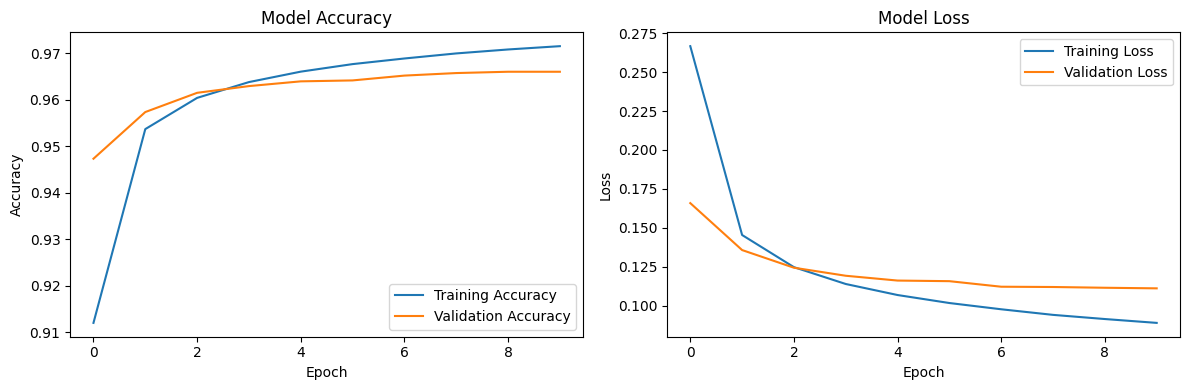

Model saved successfully as 'bilstm_model.pth'!


In [18]:
print("\\nModel Summary:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

history = train_model(model, train_loader, val_loader, epochs=10)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'history': history
}, 'bilstm_model.pth')

print("Model saved successfully as 'bilstm_model.pth'!")